In [1]:
import ccxt
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import numpy as np
from itertools import combinations
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import ta
import requests
import functions

In [2]:
# Set Binance exchange
exchange = ccxt.binance({'enableRateLimit': True})

In [3]:
def close_df(symbols,since,exchange): #1656720000000
    df = pd.DataFrame()
    # First check dates:
    series_dict = {}
    for ticker in symbols:
        symbol = f'{ticker}/USDT:USDT'
        timeframe = '1d'
        limit = 500

        all_candles_perpet = []

        since_temp = since

        while True:
            candles = exchange.fetch_ohlcv(symbol, timeframe, since_temp, limit)
            if not candles:
                break
            all_candles_perpet += candles
            since_temp = candles[-1][0] + 1  # move to the next candle after last timestamp
            time.sleep(exchange.rateLimit / 500)  # avoid rate limits (to be sure we divide by 500 and not 1000) -> rate limit is is ms
        time_and_close = np.array(all_candles_perpet)[:,[0,4]]
        df = pd.DataFrame(time_and_close, columns = ['timestamp',ticker])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        series_dict[ticker] = df
    return pd.concat(series_dict.values(), axis=1)

# Create master universe

In [ ]:
# My tickers universe

tickers = ['BTC', 'ETH', 'XRP', 'BNB', 'SOL', 'TRX', 'ADA', 'HYPE', 'SUI', 'BCH', 'LINK', 'XLM', 'AVAX', 'TON', 'LTC', 'HBAR', 'XMR', 'DOT', 'UNI', 'AAVE', 'TAO', 'APT', 'ICP', 'NEAR', 'ETC', 'ONDO', 'KAS', 'VET', 'ATOM', 'POL', 'FET', 'ENA', 'RENDER', 'FIL', 'ARB', 'WLD', 'ALGO']

In [ ]:
# Function to check if ticker is available on the exchange

def is_ticker_available(symbol):
    try:
        # Try to fetch the ticker
        exchange.fetch_ticker(symbol)
        return True
    except ccxt.BaseError:
        return False

In [ ]:
# Mask to get tickers that are available on the exchange

mask = [is_ticker_available(ticker+'/USDT:USDT') for ticker in tickers]

In [ ]:
# Get only available tickers

available_tickers = [ticker for ticker, m in zip(tickers, mask) if m]

In [ ]:
# Start date for data for insample period

start_date = datetime.datetime(2022, 1, 1)
start_timestamp = int(start_date.timestamp() * 1000)

In [ ]:
# Load prices and drop coins that didn't launch

df = close_df(set(available_tickers),start_timestamp,exchange).dropna(axis=1)

In [ ]:
# End date for data for insample period

end_of_insample = pd.Timestamp('2023-12-31')
in_sample_df = df.loc[:end_of_insample]
in_sample_df.head()

,BNB,ADA,XLM,NEAR,BCH,HBAR,ATOM,ETH,BTC,ETC,...,DOT,SOL,LTC,LINK,VET,FIL,XRP,AVAX,UNI,AAVE
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-01,527.34,1.3781,0.27665,15.1690,444.71,0.30035,36.319,3763.06,47704.35,34.862,...,28.579,179.05,150.74,20.736,0.08658,35.882,0.8507,114.107,17.462,266.26
2022-01-02,530.91,1.3769,0.29205,14.3832,447.52,0.31205,35.496,3826.21,47280.00,35.369,...,29.673,176.29,151.13,21.854,0.08710,35.733,0.8583,113.064,18.398,265.28
2022-01-03,512.24,1.3196,0.29033,16.4690,434.79,0.30681,39.229,3764.07,46445.81,34.702,...,30.089,170.18,148.43,23.697,0.08591,35.089,0.8324,108.099,18.463,267.31
2022-01-04,506.88,1.3093,0.27911,16.0387,426.80,0.32477,42.104,3785.60,45833.42,34.119,...,28.677,167.83,146.45,23.426,0.08589,36.173,0.8228,103.327,18.205,251.94
2022-01-05,473.95,1.2297,0.26592,15.2978,399.41,0.28675,38.645,3537.71,43421.69,31.912,...,26.684,154.38,135.21,25.222,0.08455,33.125,0.7718,97.358,17.098,230.32


# First Filter Step: Keep pairs with R^2 >= 0.9

In [ ]:
from statsmodels.stats.stattools import durbin_watson
import itertools 

def ols_reg(in_sample_df: pd.DataFrame):
    # Create an empty DataFrame to store results with columns for pair and R-squared value
    df = pd.DataFrame(columns=["pair", "r_squared"])

    # Generate all possible pairs of columns (excluding self-pairs)
    pairs = list(itertools.product(in_sample_df.columns.tolist(), repeat=2))
    pairs = [t for t in itertools.product(in_sample_df.columns.tolist(), repeat=2) if len(set(t)) > 1]

    # Iterate through each unique pair
    for pair in pairs:
        # Take the log of both time series in the pair
        Y = np.log(in_sample_df[pair[0]])
        X = np.log(in_sample_df[pair[1]])

        # Perform Ordinary Least Squares regression
        model = sm.OLS(Y, sm.add_constant(X))  # Add constant term to the predictor
        results = model.fit()  # Fit the model

        # Extract R-squared value
        r_squared = results.rsquared

        # If R-squared is greater than 0.9, store the pair and R-squared in the results DataFrame
        if r_squared > 0.9:
            new_row = pd.DataFrame({'pair': [(pair[0], pair[1])], 'r_squared': [r_squared]})
            df = pd.concat([df, new_row], ignore_index=True)

    # Extract just the list of selected pairs
    pairs = df['pair'].tolist()

    # Return the DataFrame of high R-squared pairs and the list of those pairs
    return df, pairs

In [12]:
ols_result, pairs = ols_reg(in_sample_df)

/var/folders/68/g1jncml17495jn3f_j8t3g1h0000gn/T/ipykernel_40380/1680752958.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


In [13]:
ols_result

,pair,r_squared
0,"(ADA, NEAR)",0.924189
1,"(ADA, HBAR)",0.900749
2,"(ADA, DOT)",0.954047
3,"(ADA, VET)",0.950006
4,"(ADA, FIL)",0.918612
5,"(ADA, AVAX)",0.948746
6,"(NEAR, ADA)",0.924189
7,"(NEAR, ALGO)",0.920913
8,"(NEAR, DOT)",0.939756
9,"(NEAR, VET)",0.902582


# Second Filter Step: Spread formation on rolling basis & Stationarity Test

In [ ]:
def spread_formation(in_sample_df: pd.DataFrame,pairs=pairs,window=90):

    data_dict = {}  # Dictionary to store calculated spread, centered spread, and beta for each pair
    for pair in pairs:  # Loop over each pair of symbols

        symbol_i = pair[0]  # First symbol in the pair
        symbol_j = pair[1]  # Second symbol in the pair

        px_i = in_sample_df[symbol_i]  # Price series of symbol_i
        px_j = in_sample_df[symbol_j]  # Price series of symbol_j

        log_px_i = np.log(px_i)  # Log-price of symbol_i
        log_px_j = np.log(px_j)  # Log-price of symbol_j

        # Rolling covariance and variance to compute rolling beta
        rolling_cov = log_px_i.rolling(window=window).cov(log_px_j)
        rolling_var = log_px_i.rolling(window=window).var()

        beta = rolling_cov / rolling_var  # Rolling beta (slope of linear relationship)
        alpha = log_px_j.rolling(window=window).mean() - beta * log_px_i.rolling(window=window).mean()  # Rolling alpha (intercept)

        # Calculate spread: difference between log_px_i and the linear combination of alpha and beta * log_px_j
        spread = log_px_i - (alpha + beta * log_px_j)

        # Rolling mean of spread
        spread_mean = spread.rolling(window=window).mean()
        centered_spread = (spread - spread_mean)  # Centered spread

        # Store the calculated series in the dictionary with tuple keys
        data_dict[(tuple(pair), 'spread')] = spread
        data_dict[(tuple(pair), 'centered_spread')] = centered_spread
        data_dict[(tuple(pair), 'beta')] = beta

    data = pd.DataFrame(data_dict)  # Create a DataFrame from the dictionary

    return data  # Return the resulting DataFrame

In [15]:
data = spread_formation(in_sample_df)

In [16]:
data.dropna(inplace=True)

In [17]:
data

(ADA, NEAR)                           (ADA, HBAR)                  \
                spread centered_spread      beta      spread centered_spread   
timestamp                                                                      
2022-06-28   -8.487730       -0.872979  1.786791    6.063913        1.289316   
2022-06-29   -8.578090       -0.950828  1.821530    6.096734        1.298435   
2022-06-30   -8.615368       -0.976470  1.855423    6.125740        1.303219   
2022-07-01   -8.720561       -1.069593  1.887559    6.151803        1.304508   
2022-07-02   -8.752297       -1.090277  1.919310    6.145856        1.273873   
...                ...             ...       ...         ...             ...   
2023-12-27   -5.399051       -0.567877  1.154514    5.395528        0.387513   
2023-12-28   -5.383631       -0.546094  1.169561    5.389100        0.371967   
2023-12-29   -5.397271       -0.552953  1.181960    5.380333        0.354412   
2023-12-30   -5.469347       -0.617037  1.193627    5.385616        0.351349   
2023-12-31   -5.512697       -0.651683  1.204531    5.382937        0.340134   

                     (ADA, DOT)                           (ADA, VET)  ...  \
                beta     spread centered_spread      beta     spread  ...   
timestamp                                                             ...   
2022-06-28  1.333532  -9.006443       -0.541614  1.172261   9.454145  ...   
2022-06-29  1.340264  -8.990213       -0.518514  1.180752   9.488531  ...   
2022-06-30  1.346317  -9.028420       -0.549047  1.188265   9.475517  ...   
2022-07-01  1.352042  -9.014727       -0.527551  1.194481   9.487876  ...   
2022-07-02  1.359228  -9.028986       -0.533097  1.201483   9.499372  ...   
...              ...        ...             ...       ...        ...  ...   
2023-12-27  0.630720  -6.956185        0.685850  0.771219   8.151941  ...   
2023-12-28  0.636352  -6.992374        0.629002  0.778775   8.159830  ...   
2023-12-29  0.641611  -7.019527        0.581759  0.785250   8.164737  ...   
2023-12-30  0.645189  -7.065070        0.516899  0.792047   8.148244  ...   
2023-12-31  0.648546  -7.087037        0.476074  0.797787   8.169187  ...   

           (AVAX, DOT) (AVAX, VET)                           (AVAX, FIL)  \
                  beta      spread centered_spread      beta      spread   
timestamp                                                                  
2022-06-28    0.600372   16.385487       -2.864512  0.631714    2.906612   
2022-06-29    0.601613   16.363437       -2.810084  0.629434    2.896206   
2022-06-30    0.601004   16.272230       -2.822476  0.625067    2.845593   
2022-07-01    0.599853   16.199218       -2.814369  0.621593    2.789485   
2022-07-02    0.597917   16.153204       -2.778478  0.616139    2.787809   
...                ...         ...             ...       ...         ...   
2023-12-27    0.432885   15.118472        1.045657  0.411670    2.077904   
2023-12-28    0.437777   15.111243        1.025291  0.416490    2.005972   
2023-12-29    0.442050   15.165513        1.064564  0.421103    2.038532   
2023-12-30    0.446769   15.176858        1.060369  0.425630    2.013158   
2023-12-31    0.450856   15.199905        1.066474  0.428839    1.961445   

                                     (AAVE, VET)                            
           centered_spread      beta      spread centered_spread      beta  
timestamp                                                                   
2022-06-28       -0.286641  0.850014   22.692784        0.037578  0.915363  
2022-06-29       -0.276390  0.849459   22.613756       -0.046633  0.907521  
2022-06-30       -0.308179  0.846782   22.483447       -0.179000  0.901485  
2022-07-01       -0.346643  0.844818   22.434642       -0.229382  0.897236  
2022-07-02       -0.333785  0.841734   22.378860       -0.285831  0.891160  
...                    ...       ...         ...             ...       ...  
2023-12-27       -0.315506  0.308421   25.786333     

In [ ]:
def cointegration(data, pairs=pairs, threshold=0.05):

    new_pairs = []  # To store pairs that are cointegrated
    df = pd.DataFrame(columns=["coin_1", "coin_2", "p_value", "test_stat"])  # DataFrame to store test results

    for pair in pairs:  # Loop over each pair
        spread = data[(pair, 'spread')].values  # Retrieve the spread series for the pair
        adf_test = adfuller(spread)  # Perform Augmented Dickey-Fuller test on the spread
        test_statistic = adf_test[0]  # Extract test statistic
        p_val = adf_test[1]  # Extract p-value from ADF result

        # If the p-value is below the threshold, consider the pair cointegrated
        if p_val < threshold:
            new_pairs.append(pair)  # Store the cointegrated pair
            # Create a new row with test results and append to the DataFrame
            new_row = pd.DataFrame({'coin_1': [pair[0]], 'coin_2': [pair[1]], 'p_value': [p_val], 'test_stat': [test_statistic]})
            df = pd.concat([df, new_row], ignore_index=True)  # Append new row to result DataFrame

    return new_pairs, df  # Return the list of cointegrated pairs and the results DataFrame

In [19]:
new_pairs,coint_df = cointegration(data)

/var/folders/68/g1jncml17495jn3f_j8t3g1h0000gn/T/ipykernel_40380/3368074136.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


In [21]:
temp = []
unique_transitions = []
for pair in new_pairs:
    if pair[0] not in temp and pair[1] not in temp:
        temp.append(pair[0])
        temp.append(pair[1])
        unique_transitions.append(pair[0])

In [22]:
def filter(df):
    keep_indices = []
    for ticker in unique_transitions:
        keep_indices.append(df[(df['coin_1'] == ticker) | (df['coin_2'] == ticker)].sort_values(by='test_stat').index[0])

    sorted_df = df.sort_values(by=['coin_1','test_stat']).drop_duplicates(subset=['coin_1'])
    sorted_df = sorted_df.sort_values(by=['coin_2','test_stat']).drop_duplicates(subset=['coin_2'])
    sorted_df = sorted_df[sorted_df.index.isin(set(keep_indices))]
    sorted_df.reset_index(drop=True,inplace=True)
    
    return sorted_df

In [23]:
new_df = filter(coint_df)

In [24]:
final_pairs = new_df[['coin_1','coin_2']].values.tolist()

# Visualisation of pair spreads

/var/folders/68/g1jncml17495jn3f_j8t3g1h0000gn/T/ipykernel_40380/95652194.py:3: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(data[((pair[0],pair[1]), 'centered_spread')], label=pair)


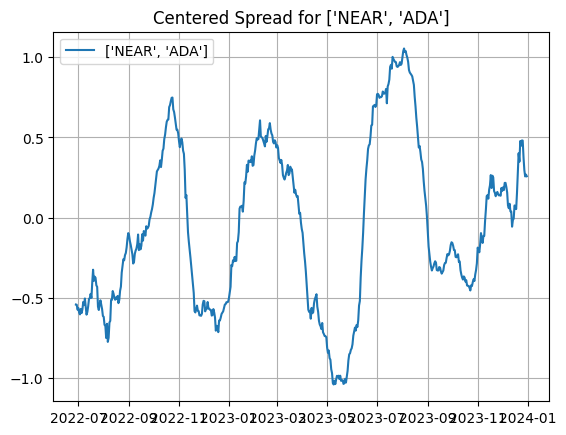

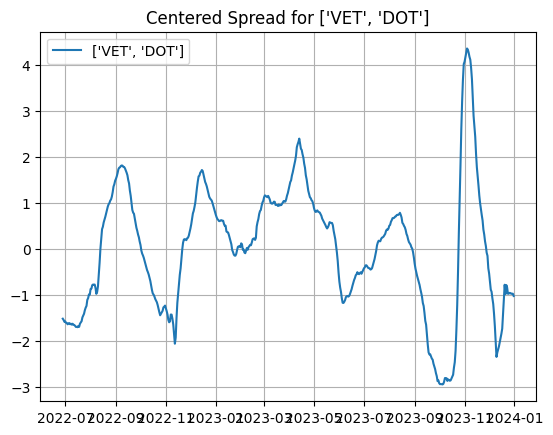

In [25]:
for pair in final_pairs:
    plt.figure()  # This creates a new window/figure
    plt.plot(data[((pair[0],pair[1]), 'centered_spread')], label=pair)
    plt.title(f'Centered Spread for {pair}')
    plt.legend()
    plt.grid()
    plt.show()

# Backtest

In [31]:
start_of_out_sample = end_of_insample + pd.DateOffset(days=1)
end_of_out_sample = start_of_out_sample + pd.DateOffset(years=1)

In [57]:
def generate_weights(signals_df, threshold=0.5):

    pairs = signals_df.columns.get_level_values(0).unique().tolist()  # Extract unique asset pairs from MultiIndex columns
    signals_df = signals_df.loc[start_of_out_sample:end_of_out_sample]  # Restrict the signals DataFrame to the out-of-sample period

    pos = pd.DataFrame(index=signals_df.index, columns=in_sample_df.columns, dtype=float)  # Initialize a DataFrame to hold positions

    tickers = [ticker for pair in pairs for ticker in pair]  # Flatten the list of asset pairs into a list of tickers
   
    # Loop over each asset pair
    for pair in pairs:
        asset_i = pair[0]  # First asset in the pair
        asset_j = pair[1]  # Second asset in the pair

        betas = signals_df[(tuple(pair), 'beta')]  # Extract beta values for the pair

        spread = signals_df[(tuple(pair), 'centered_spread')]
        fast_sma = spread.rolling(8).mean()  # Short-term moving average
        slow_sma = spread.rolling(16).mean()  # Long-term moving average

        diff = fast_sma.diff()  # Change in fast moving average (not used in logic here)

        short_pos = 0  # Flag indicating short position status
        long_pos = 0  # Flag indicating long position status

        long_trigger = False  # Signal trigger for long entry
        short_trigger = False  # Signal trigger for short entry

        # Loop over each time index
        for ind in pos.index:

            # Maintain long position
            if long_pos == 1:
                pos.loc[ind, asset_j] = -betas.loc[ind]
                pos.loc[ind, asset_i] = 1

            # Maintain short position
            elif short_pos == 1:
                pos.loc[ind, asset_j] = betas.loc[ind]
                pos.loc[ind, asset_i] = -1

            # Detect short entry signal (crossing from below to above zero)
            if (spread.loc[ind] > 0) and (spread.shift().loc[ind] <= 0):
                short_trigger = True
                long_trigger = False

            # Detect long entry signal (crossing from above to below zero)
            elif (spread.loc[ind]) < 0 and (spread.shift().loc[ind] >= 0):
                long_trigger = True
                short_trigger = False

            # Execute short entry if conditions met
            if (short_trigger == True) and (fast_sma.loc[ind] < slow_sma.loc[ind]) and (short_pos == 0) and (np.abs(spread.loc[ind]) > threshold):
                pos.loc[ind, asset_i] = -1
                pos.loc[ind, asset_j] = betas.loc[ind]
                short_pos = 1
                short_trigger = False

            # Execute long entry if conditions met
            elif (long_trigger == True) and (fast_sma.loc[ind] > slow_sma.loc[ind]) and (long_pos == 0) and (np.abs(spread.loc[ind]) > threshold):
                pos.loc[ind, asset_i] = 1
                pos.loc[ind, asset_j] = -betas.loc[ind]
                long_pos = 1
                long_trigger = False

            # Exit short position if centered spread returns to neutral threshold
            if (short_pos == 1) and (np.abs(spread.loc[ind]) <= threshold):
                pos.loc[ind, asset_i] = 0 
                pos.loc[ind, asset_j] = 0
                short_pos = 0

            # Exit long position if centered spread returns to neutral threshold
            elif (long_pos == 1) and (np.abs(spread.loc[ind]) <= threshold):
                pos.loc[ind, asset_j] = 0  
                pos.loc[ind, asset_i] = 0
                long_pos = 0
            
    # Forward-fill any NaNs in the position matrix
    pos = pos.ffill()

    # Normalize positions row-wise and account for number of active pairs
    pos_final = (pos.divide(pos.abs().sum(axis=1), axis=0).fillna(0))

    return pos_final  # Return the final normalized position matrix


In [ ]:
spreads = spread_formation(df,pairs=final_pairs,window=90)
spreads.dropna(inplace=True)

In [52]:
wts = generate_weights(spreads, threshold=0.001)

In [53]:
coins_ret = df.pct_change().dropna()

In [54]:
def compute_turnover(port):
    to = (port.fillna(0)-port.shift().fillna(0)).abs().sum(1)   
    return to

In [55]:
# Calculate out-of-sample daily returns (we shift to avoid look ahead biais)
out_sample_ret = coins_ret.loc[start_of_out_sample:end_of_out_sample]
strat_gross_ret = (wts.shift() * out_sample_ret).sum(1)
    
# Calculate net returns
to = compute_turnover(wts)
tcost_bps = 20  # (commissions + slippage)
strat_net_ret = strat_gross_ret.subtract(to * tcost_bps * 1e-4, fill_value=0)

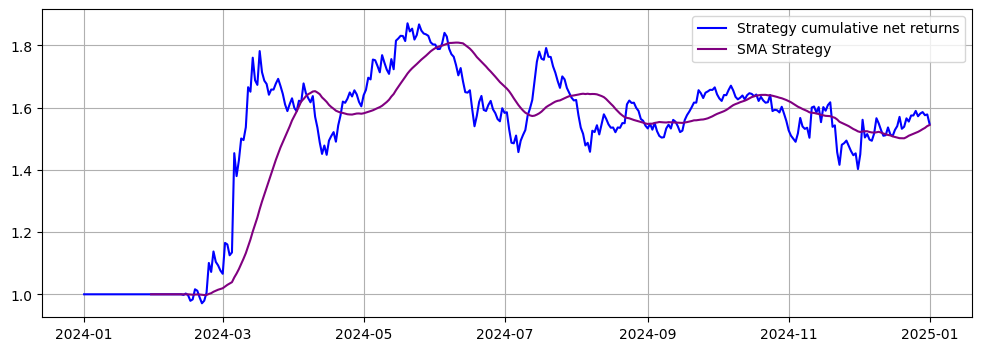

In [56]:
plt.figure(figsize=(12, 4))
plt.plot((1+strat_net_ret).cumprod(),label='Strategy cumulative net returns',color='blue')
plt.plot((1+strat_net_ret).cumprod().rolling(30).mean(),color = 'purple',label='SMA Strategy')
plt.legend()
plt.grid()

/var/folders/68/g1jncml17495jn3f_j8t3g1h0000gn/T/ipykernel_40380/1510478640.py:3: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(spreads[((pair[0],pair[1]), 'centered_spread')].loc[:end_of_out_sample], label=pair)


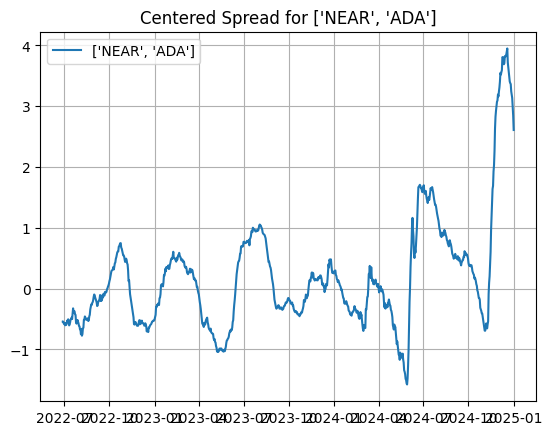

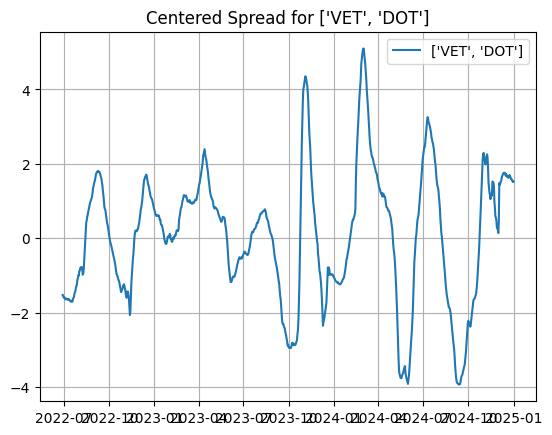

In [48]:
for pair in final_pairs:
    plt.figure()  # This creates a new window/figure
    plt.plot(spreads[((pair[0],pair[1]), 'centered_spread')].loc[:end_of_out_sample], label=pair)
    plt.title(f'Centered Spread for {pair}')
    plt.legend()
    plt.grid()
    plt.show()